In [33]:
import pandas as pd
import numpy as np
import os
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction as aF
from pathlib import Path

from pandas_ml import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, recall_score
from sklearn.decomposition import PCA 

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

from scipy.stats import kurtosis, skew

from itertools import product

In [34]:
path_data = Path('../data/')
df_labels = labels = pd.read_csv(path_data/'ComParE2018_AtypicalAffect.txt', sep="\t")
df_labels['subset'] = df_labels['file_name'].str.split('_').apply(lambda x: x[0])
df_labels.head()


X_train, y_train = ((df_labels.loc[(df_labels['subset']=='train')][['file_name']]), 
                    df_labels.loc[df_labels['subset']=='train']['emotion'])

X_devel, y_devel = (df_labels.loc[df_labels['subset']=='devel'][['file_name']], 
                    df_labels.loc[df_labels['subset']=='devel']['emotion'])

X_test, y_test = (df_labels.loc[df_labels['subset']=='test'][['file_name']], 
                    df_labels.loc[df_labels['subset']=='test']['emotion'])

In [35]:
# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# np.unique(y_resampled, return_counts=True)

In [36]:
class ReadRawData(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_c = X.copy()
        df_sample_data = X_c['file_name'].apply(lambda x: audioBasicIO.readAudioFile(path_data/'wav'/x))
        X_c['sample_rate'] = df_sample_data.apply(lambda x: x[0])
        X_c['raw_data'] = df_sample_data.apply(lambda x: x[1])
        X_c['duration'] = X_c['raw_data'].apply(lambda x: x.size)/X_c['sample_rate']
        return X_c
        
rrd = ReadRawData()
X_train = rrd.fit_transform(X_train)
X_devel = rrd.transform(X_devel)
X_test =rrd.transform(X_test)

In [31]:
class PyAudioAnalysisFeaturesFactory(BaseEstimator, TransformerMixin):
    
    def __init__(self, 
                 limit_to=4, #parameter to control where to truncate (or pad)
                 pad=['resize', 'zero', 'mean', 'stat'][0], # what kind of padding to use
                 frame_size=0.05, #PyAudio default
                 frame_step=0.025,#PyAudio default
                 keep_duration=True, #to keep duration as a feature
                 print_every=50
                ):
        self.limit_to, self.pad = limit_to, pad
        self.frame_size, self.frame_step = frame_size, frame_step
        self.keep_duration = keep_duration
        self.key = f'{limit_to}_{pad}_{frame_size}_{frame_step}_{keep_duration}'
        self.counter, self.print_every = 0, print_every

    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        X_c = X.copy().reset_index(drop=True)
        if self.pad == 'stat':
            features = X_c.apply(lambda x: self.add_features_functionals((x['sample_rate'], 
                                                                          x['raw_data'])), 
                                 axis=1)
            features = pd.DataFrame(features.values.tolist())
        else:
            features = X_c.apply(lambda x: self.add_features((x['sample_rate'], x['raw_data'])), axis=1)
            # these steps are just for getting the column names
            x = X_c['raw_data'].iloc[0]
            fs = X_c['sample_rate'].iloc[0]
            s, t = aF.stFeatureExtraction(np.resize(x,(fs*self.limit_to,)),
                                          fs,
                                          self.frame_size*fs,
                                          self.frame_step*fs)
            col_names = np.array([f'{name}_{i}' for i in range(s.shape[1]) for name in t]).reshape(-1)
            features = pd.DataFrame(features.values.tolist(), columns=col_names)
        
        if self.keep_duration:
            features['duration'] = X_c['duration']
        return features.astype(np.float32)
            
            
    def add_features(self, res):
        if self.counter%self.print_every == 0:
            print(self.counter)
        self.counter += 1
        fs,x = res
        diff = (self.limit_to*fs)-x.shape[0]
        if self.pad == 'resize':
            x = np.resize(x,(fs*self.limit_to,))
        elif self.pad == 'zero':
            x = np.hstack([np.zeros(diff), x]) if diff>0 else x[:(self.limit_to*fs)]
        else:
            x = np.hstack([np.repeat(x.mean(), diff), x]) if diff>0 else x[:(self.limit_to*fs)]
            
        s,t = aF.stFeatureExtraction(x,fs,self.frame_size*fs,self.frame_step*fs)
        s = s.T.reshape(-1)
        return s
    
    def add_features_functionals(self, res):
        if self.counter%self.print_every == 0:
            print(self.counter, end=' ')
        self.counter += 1
        fs,x = res
        s,t = aF.stFeatureExtraction(x,fs,self.frame_size*fs,self.frame_step*fs)
        summarized_functionals = np.hstack([
            s.mean(axis=1), 
            s.min(axis=1), 
            s.max(axis=1), 
            s.std(axis=1),
            s.var(axis=1),
            skew(s, axis=1),
            kurtosis(s, axis=1)
            
        ])
        return summarized_functionals

    
class PyAudioAnalysisFeatures(PyAudioAnalysisFeaturesFactory, BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        PyAudioAnalysisFeaturesFactory.__init__(self, **kwargs)
        
    def fit(self):
        return self
    
    def transform(self, X):
        X_base = feature_dict[self.key]
        return X_base.loc[X.index]

In [118]:
# feature_transform_params = {
#     'limit_to': [2, 4, 6],
#     'pad': ['resize', 'zero', 'mean']
# }


# feature_transform_param_combs = [dict(zip(feature_transform_params.keys(),v))
#                                  for v in product(*feature_transform_params.values())]
    

# feature_dict = dict()

# for i in feature_transform_param_combs:
#     print(i)
#     paaff = PyAudioAnalysisFeaturesFactory(**i)
#     feature_dict[paaff.key] = paaff.fit_transform(X_train_all)

# paaff = PyAudioAnalysisFeaturesFactory(pad='stat')
# feature_dict[paaff.key] = paaff.fit_transform(X_train_all)


In [ ]:
# feature_dict = dict()
paaff = PyAudioAnalysisFeaturesFactory(pad='stat')
X_train_summary = paaff.fit_transform(X_train)

0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 

In [ ]:
X_test_summary = paaff.fit_transform(X_test)

In [ ]:
X_devel_summary = paaff.fit_transform(X_devel)

In [17]:
# model = AdaBoostClassifier(DecisionTreeClassifier(), 
#                                  n_estimators=10, learning_rate=1.0)

model = Pipeline([
    ('oversampling', RandomOverSampler(random_state=0)),
    ('model', DecisionTreeClassifier())
])

model.fit(X_train_summary, y_train) #.drop('duration', axis=1)
y_predtree = model.predict(X_devel_summary)
reporting(y_devel,y_predtree)

NameError: name 'X_tr_dl' is not defined

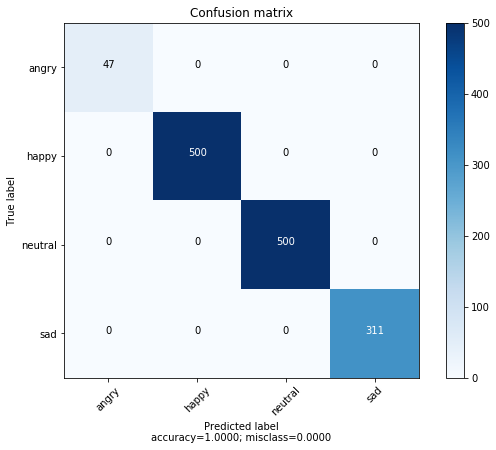

<function confusion_matrix at 0x7fd4a01b1268>

               precision    recall  f1-score   support

       angry       1.00      1.00      1.00        47
       happy       1.00      1.00      1.00       500
     neutral       1.00      1.00      1.00       500
         sad       1.00      1.00      1.00       311

   micro avg       1.00      1.00      1.00      1358
   macro avg       1.00      1.00      1.00      1358
weighted avg       1.00      1.00      1.00      1358

1.0


In [114]:
y_predtree = model.predict(X_tr_dl.drop('duration', axis=1))
reporting(y_tr_dl,y_predtree)

In [30]:
model_pipeline = pipeline.Pipeline([
    ('features', PyAudioAnalysisFeatures()),
    ('pca', PCA(n_components=500)),
    ('model', AdaBoostClassifier(DecisionTreeClassifier(class_weight={'neutral': 100000, 
                                                                      'happy': 100, 
                                                                      'sad': 1, 
                                                                      'angry':1}), 
                                 n_estimators=100, learning_rate=10.0))
])

param_grid = {
    'pca__n_components': [15, 50, 100, 250, 500],
    'model__class_weight': [
                        {'neutral': 1, 'happy': 1, 'sad': 100000, 'angry':100000},
                        {'neutral': 100000, 'happy': 100000, 'sad': 1, 'angry':1}
                    ],
    'model__learning_rate': [0.1, 1, 10.0]
}

for k,v in feature_transform_params:
    param_grid['features__'+k] = v
    
# custom scoring - Unweighted Average Recall (from the paper),  
# because our data is imbalanced
uar = make_scorer(recall_score, average='macro')

model_pipeline_cv = GridSearchCV(
    estimator= model_pipeline, #use the model
    param_grid=param_grid, # generate combinations from the parameter grid
    scoring=uar, #UAR to pick the best params
    n_jobs=4, # use these many cores for faster parallel processing
    cv=5, # k fold cv
    refit=True, # refit the best parameters on all of the data
    verbose=50, #give detailed progress
    iid=True)

model_pipeline_cv.fit(X_train_all, y_train_all)

KeyboardInterrupt: 

In [54]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def reporting(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, target_names=np.unique(y_train))
    print(confusion_matrix)
    print("\n",classification_report(y_test,y_pred))
    print(accuracy_score(y_test,y_pred))

In [ ]:
y_pred = model_pipeline.predict(X_test)

In [ ]:
reporting(y_test,y_pred)

In [ ]:
classification_report(y_test,y_pred)